# Аналіз найпопулярніших логістичних маршрутів

## Завантаження та очищення даних

Було завантажено таблицю з Excel-файлу. Записи з пропущеними значеннями в ключових полях (`Rate`, `Miles`, `From City`, `To City`, `RPM`) були видалені. Числові поля приведено до типу `float` для подальших обчислень.

In [1]:
import pandas as pd

df = pd.read_excel("../Loads 2024.xlsx", sheet_name="DATA")

df = df.dropna(subset=["Rate", "Miles", "From City", "From State", "To City", "To State", "RPM"])
df["Miles"] = pd.to_numeric(df["Miles"], errors="coerce")
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
df["RPM"] = pd.to_numeric(df["RPM"], errors="coerce")

## Формування маршруту

Для кожного запису було створено колонку `Route`, яка представляє собою напрямок у форматі `Місто, Штат → Місто, Штат`. Це дозволяє легко ідентифікувати унікальні маршрути для агрегації.

In [2]:
df["Route"] = df["From City"].str.strip() + ", " + df["From State"].str.strip() + " → " + df[
    "To City"].str.strip() + ", " + df["To State"].str.strip()

unique_routes_count = df["Route"].nunique()

## Підрахунок кількості унікальних маршрутів

Підраховано кількість унікальних маршрутів у базі даних, що дає уявлення про географічне різноманіття перевезень.

In [3]:
print(f"Унікальних маршрутів у базі даних: {unique_routes_count}")

Унікальних маршрутів у базі даних: 4798


## Визначення найпопулярніших маршрутів

Було підраховано, скільки разів кожен маршрут зустрічається у даних. Отримано датафрейм `top_popular_routes`, який містить маршрути з найбільшою кількістю повторень.

In [4]:
df["Route"] = (
    df["From City"].str.strip() + ", " +
    df["From State"].str.strip() + " → " +
    df["To City"].str.strip() + ", " +
    df["To State"].str.strip()
)

route_counts = df["Route"].value_counts().reset_index()
route_counts.columns = ["Route", "Count"]


top_popular_routes = route_counts

top_popular_routes.head(10)

,Route,Count
0,"BENSENVILLE, IL → SPARKS, NV",71
1,"LEBANON, IN → STOCKTON, CA",61
2,"RENO, NV → HANOVER PARK, IL",50
3,"VACAVILLE, CA → COLUMBUS, OH",49
4,"TOLUCA, IL → FORT WORTH, TX",48
5,"BOLINGBROOK, IL → FONTANA, CA",45
6,"ROCHELLE, IL → WOODLAND, CA",42
7,"OOSTBURG, WI → METHUEN, MA",42
8,"BELVIDERE, IL → CLEBURNE, TX",42
9,"OWASSO, OK → MELROSE PARK, IL",41


## Побудова графіка найпопулярніших маршрутів

З даних обрано топ-5 маршрутів з найбільшою кількістю повторень. Створено barplot, де по осі Y — місто відправлення, а по X — кількість повторень. Колір відповідає місту призначення.

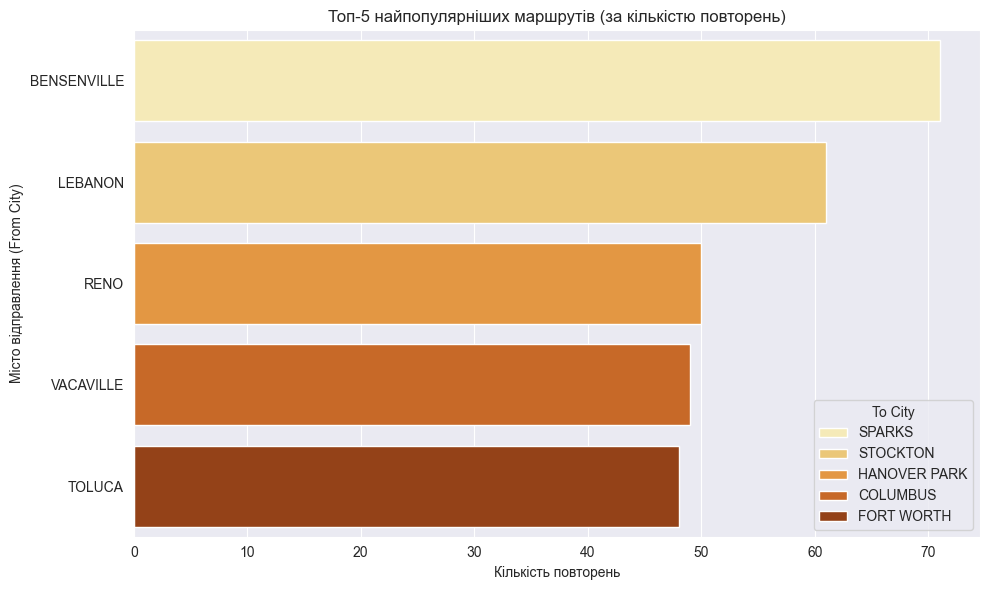

In [5]:
top_popular_routes["From City"] = top_popular_routes["Route"].apply(lambda x: x.split("→")[0].split(",")[0].strip())
top_popular_routes["To City"] = top_popular_routes["Route"].apply(lambda x: x.split("→")[1].split(",")[0].strip())

import matplotlib.pyplot as plt
import seaborn as sns

top5 = top_popular_routes.sort_values("Count", ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5,
    y="From City",
    x="Count",
    hue="To City",
    palette="YlOrBr"
)
plt.title("Топ-5 найпопулярніших маршрутів (за кількістю повторень)")
plt.xlabel("Кількість повторень")
plt.ylabel("Місто відправлення (From City)")
plt.tight_layout()
plt.show()

## Побудова карти топ-5 маршрутів

За допомогою бібліотек `geopy`, `openrouteservice` і `folium` візуалізовано найпопулярніші маршрути на карті США. Для кожного маршруту:

- здійснено геокодування міст,
- запитано побудову маршруту через OpenRouteService,
- додано маркери для початкової та кінцевої точок маршруту.

In [6]:
from geopy import Nominatim
import folium
import time
import openrouteservice
from openrouteservice import convert
from tqdm import tqdm

ORS_API_KEY = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjRkNDI3MjgwYTJjZDRhYzNhMzVlZjM5ZTY5NmM2N2YyIiwiaCI6Im11cm11cjY0In0="

top5_routes = top_popular_routes.head(5).copy()

top5_routes[["From", "To"]] = top5_routes["Route"].str.split(" → ", expand=True)
top5_routes[["From City", "From State"]] = top5_routes["From"].str.split(", ", expand=True)
top5_routes[["To City", "To State"]] = top5_routes["To"].str.split(", ", expand=True)

top5_routes = top5_routes.drop(columns=["Route", "From", "To"])
geolocator = Nominatim(user_agent="logistics-map")
ors_client = openrouteservice.Client(key=ORS_API_KEY)
m_popular = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in tqdm(top5_routes.iterrows(), total=top5_routes.shape[0]):
    from_city = row["From City"]
    from_state = row["From State"]
    to_city = row["To City"]
    to_state = row["To State"]
    count = row["Count"]

    try:
        from_loc = geolocator.geocode(f"{from_city}, {from_state}", timeout=10)
        to_loc = geolocator.geocode(f"{to_city}, {to_state}", timeout=10)

        time.sleep(1)

        if from_loc and to_loc:
            from_coords = (from_loc.latitude, from_loc.longitude)
            to_coords = (to_loc.latitude, to_loc.longitude)

            coords = [(from_coords[1], from_coords[0]), (to_coords[1], to_coords[0])]

            route = ors_client.directions(coords)
            decoded = convert.decode_polyline(route['routes'][0]['geometry'])

            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in decoded["coordinates"]],
                tooltip=f"{from_city} → {to_city} | Кількість: {count}",
                color="orange"
            ).add_to(m_popular)

            folium.Marker(location=from_coords, popup=f"{from_city}, {from_state}",
                          icon=folium.Icon(color="green")).add_to(m_popular)
            folium.Marker(location=to_coords, popup=f"{to_city}, {to_state}",
                          icon=folium.Icon(color="red")).add_to(m_popular)
        else:
            print("Пропущено (немає координат):", from_city, "→", to_city)

    except openrouteservice.exceptions.ApiError as e:
        print(f"Помилка маршруту {from_city} → {to_city}: {e}")
    except Exception as e:
        print(f"Інша помилка для маршруту {from_city} → {to_city}: {e}")

m_popular

/Users/pavlovaskiv/PycharmProjects/LogiTrack/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 5/5 [00:12<00:00,  2.43s/it]
